In [ ]:
!wget https://github.com/karoldvl/ESC-50/archive/master.zip

In [ ]:
!unzip master.zip

### Handling dataset

In [1]:
import os
import pandas as pd
import torchaudio
import torch
from torch.utils.data import Dataset
import torchaudio.transforms as T
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
annotations = pd.read_csv("./ESC-50-master/meta/esc50.csv")

In [3]:
annotations.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [4]:
print(annotations.iloc[0, 0]) # Filename
print(annotations.iloc[0, 2]) # Label

1-100032-A-0.wav
0


In [5]:
annotations.fold.value_counts()

1    400
2    400
3    400
4    400
5    400
Name: fold, dtype: int64

In [6]:
class_name_to_idx = {}
class_idx_to_name = {}

for _, row in annotations.iterrows():
    category = row[3]
    label = row[2]
    if category not in class_name_to_idx:
        class_name_to_idx[category] = label
        class_idx_to_name[label] = category

In [7]:
class ESC50Dataset(Dataset):
  def __init__(self, csv_file, root_dir, split="train"):
    if split == "train":
      self.len = 1600
      self.shift = 0
    else:
      self.len = 400
      self.shift = 1600
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = Compose([
      T.MelSpectrogram(sample_rate=44100, n_fft=1024, hop_length=512, n_mels=64),
      T.AmplitudeToDB()
    ])

  def __len__(self):
    return self.len

  def __getitem__(self, index):
    index = self.shift + index
    audio_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    label = self.annotations.iloc[index, 2]

    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = self.transform(waveform)
    
    return waveform, label

In [8]:
csv_file = "ESC-50-master/meta/esc50.csv"
root_dir = "ESC-50-master/audio"

dataset = ESC50Dataset(csv_file, root_dir, "train")

### Architecture based on ResNet

In [9]:
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.downsample = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
        nn.BatchNorm2d(out_channels)
    ) if stride != 1 or in_channels != out_channels else nn.Identity()

  def forward(self, x):
    identity = x
    identity = self.downsample(identity)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x += identity
    x = self.relu(x)
    x = self.dropout(x)
    return x

In [10]:

class SoundClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.con1 = nn.Conv2d(1, 16, kernel_size=7, stride=2, padding=3, bias=False)
    self.dropout = nn.Dropout(0.2)
    self.bn1 = nn.BatchNorm2d(16)
    self.layers = nn.Sequential(
        ResBlock(16, 16, 1),
        ResBlock(16, 32, 2),
        ResBlock(32, 32, 1),
        ResBlock(32, 32, 1),
        ResBlock(32, 64, 2),
        ResBlock(64, 64, 1),
        ResBlock(64, 64, 1),
        ResBlock(64, 128, 2)
        )
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(128, 50)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.bn1(self.con1(x)))
    x = self.dropout(x)
    x = self.layers(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

### Training

In [11]:
classifier = SoundClassifier().cuda()
criterion = nn.BCEWithLogitsLoss()
# classifier.load_state_dict(torch.load("./checkpoint"))

lr = 0.001
batch_size = 128
optimizer = Adam(classifier.parameters(), lr=lr)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
dataset_val = ESC50Dataset(csv_file, root_dir, split="val")
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [13]:
@torch.no_grad
def calculate_accuracy(dataloader):
    # Evaluation
    all_preds = []
    all_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.cuda()
        outputs = classifier(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

In [14]:
@torch.no_grad
def get_val_loss():
    val_loss = 0
    n = 0
    for inputs, labels in dataloader_val:
        labels = nn.functional.one_hot(labels, num_classes=50).float().cuda()
        inputs = inputs.cuda()

        outputs = classifier(inputs)
        val_loss += criterion(outputs, labels)
        n += 1
    return (val_loss/n).detach().item()

In [15]:
n_epoch = 100
classifier.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

classifier.train()

for epoch in range(n_epoch):
  for inputs, labels in dataloader:
    optimizer.zero_grad()

    labels = nn.functional.one_hot(labels, num_classes=50).float().cuda()
    inputs = inputs.cuda()

    outputs = classifier(inputs)
    loss = criterion(outputs, labels)


    loss.backward()
    optimizer.step()
  print(f"EPOCH {epoch+1} | Loss: {loss.detach().item():.4f}")
  
  train_losses.append(loss.detach().item())
  val_losses.append(get_val_loss())
  train_accuracies.append(calculate_accuracy(dataloader))
  val_accuracies.append(calculate_accuracy(dataloader_val))


EPOCH 1 | Loss: 0.3451
EPOCH 2 | Loss: 0.1401
EPOCH 3 | Loss: 0.1020
EPOCH 4 | Loss: 0.0950
EPOCH 5 | Loss: 0.0917
EPOCH 6 | Loss: 0.0941
EPOCH 7 | Loss: 0.0909
EPOCH 8 | Loss: 0.0879
EPOCH 9 | Loss: 0.0894
EPOCH 10 | Loss: 0.0928
EPOCH 11 | Loss: 0.0887
EPOCH 12 | Loss: 0.0899
EPOCH 13 | Loss: 0.0846
EPOCH 14 | Loss: 0.0840
EPOCH 15 | Loss: 0.0823
EPOCH 16 | Loss: 0.0784
EPOCH 17 | Loss: 0.0763
EPOCH 18 | Loss: 0.0770
EPOCH 19 | Loss: 0.0789
EPOCH 20 | Loss: 0.0691
EPOCH 21 | Loss: 0.0697
EPOCH 22 | Loss: 0.0674
EPOCH 23 | Loss: 0.0683
EPOCH 24 | Loss: 0.0631
EPOCH 25 | Loss: 0.0621
EPOCH 26 | Loss: 0.0597
EPOCH 27 | Loss: 0.0612
EPOCH 28 | Loss: 0.0581
EPOCH 29 | Loss: 0.0535
EPOCH 30 | Loss: 0.0533
EPOCH 31 | Loss: 0.0530
EPOCH 32 | Loss: 0.0504
EPOCH 33 | Loss: 0.0506
EPOCH 34 | Loss: 0.0468
EPOCH 35 | Loss: 0.0482
EPOCH 36 | Loss: 0.0478
EPOCH 37 | Loss: 0.0446
EPOCH 38 | Loss: 0.0425
EPOCH 39 | Loss: 0.0424
EPOCH 40 | Loss: 0.0384
EPOCH 41 | Loss: 0.0324
EPOCH 42 | Loss: 0.0337
E

In [16]:
torch.save(classifier.state_dict(), "./checkpoint")

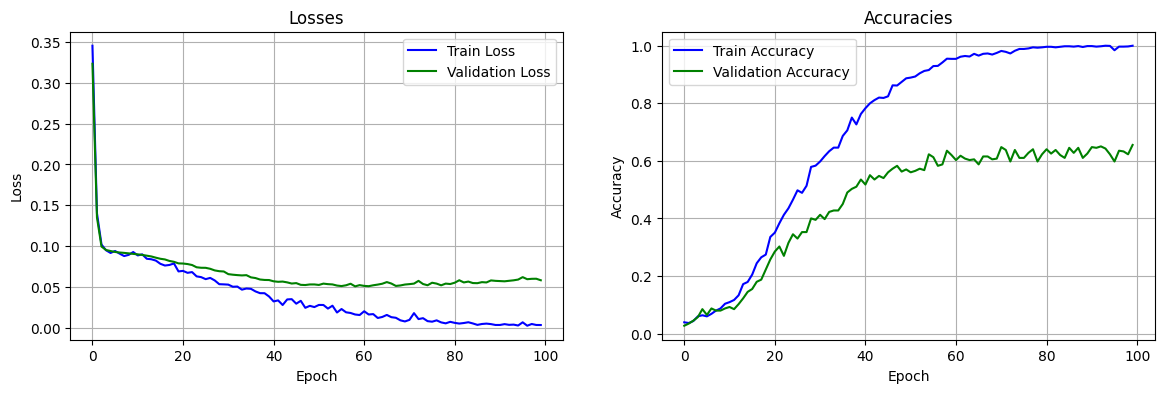

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].set_title("Losses")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].plot(train_losses, c="blue", label="Train Loss")
ax[0].plot(val_losses, c="green", label="Validation Loss")
ax[0].legend()
ax[0].grid()

ax[1].set_title("Accuracies")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].plot(train_accuracies, c="blue", label="Train Accuracy")
ax[1].plot(val_accuracies, c="green", label="Validation Accuracy")
ax[1].legend()
ax[1].grid()


fig.savefig("./progress.png")

In [18]:
training_acc, val_acc = calculate_accuracy(dataloader), calculate_accuracy(dataloader_val)
print(f"Training Accuracy: {training_acc*100:.2f}% \nValidation Accuracy: {val_acc*100:.2f}%")

Training Accuracy: 99.94% 
Validation Accuracy: 65.50%


In [19]:
from IPython.display import Audio

In [20]:
audio_path = "ESC-50-master/audio/5-256452-A-5.wav"
correct_label = audio_path[audio_path.rfind("-", )+1:-4]
print("Correct Label: ", correct_label)
Audio(filename=audio_path)

Correct Label:  5


In [21]:
# SHOULD BE 5 seconds
waveform, sample_rate = torchaudio.load(audio_path)
transform = Compose([
      T.MelSpectrogram(sample_rate=44100, n_fft=1024, hop_length=512, n_mels=64),
      T.AmplitudeToDB()
    ])
model_input = transform(waveform)

In [22]:
classifier.eval()
model_unsqueezed_input = model_input.cuda().unsqueeze(0)
with torch.no_grad():
    output = classifier(model_unsqueezed_input)
    softmaxed_out = torch.softmax(output, -1)
    out = softmaxed_out.argmax()
    print(out.item())
    print(f"Audio category: {class_idx_to_name[out.detach().item()]}")

5
Audio category: cat
